In [1]:
import warnings
import logging
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*NOT subset.*")
logging.getLogger("fontTools.subset").setLevel(logging.ERROR)

import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import gridspec
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib import colors
import scipy.sparse
from upsetplot import UpSet
import decoupler as dc
import gseapy as gp

sc._settings.ScanpyConfig(n_jobs=-1)

In [2]:
# Path to font
helvetica_neue_path = Path.home() / ".local/share/fonts/HelveticaNeue-Regular.ttf"

# Create a FontProperties object
prop_neue = fm.FontProperties(fname=helvetica_neue_path)
helvetica_neue_name = prop_neue.get_name()

# Custom font/graphing for Seaborn
custom_context = {
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 7,
    'axes.linewidth': 0.6,
    'grid.linewidth': 0.6,
    'lines.linewidth': 0.6,
    'lines.markersize': 3,
    'patch.linewidth': 0.6,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.title_fontsize': 7,
}

# Additional custom aesthetics for Seaborn
custom_style = {
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.color': '#EAEAEA',
    'grid.linestyle': '--',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'ytick.left': True,
    'xtick.bottom': True,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
}

# Use set_theme and pass rc with font settings
sns.set_theme(
    context=custom_context,
    style=custom_style,
    rc={
        'font.family': 'sans-serif',
        'font.sans-serif': [helvetica_neue_name],
        'font.size': 7,
        'axes.labelsize': 7,
        'axes.titlesize': 7,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7
    }
)

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# Set root and output directory
REPO_ROOT = Path.cwd().resolve()
output_dir = REPO_ROOT / "figure5_outputs"
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Import anndata object
adata_path = (REPO_ROOT / "GSE290679_10069-MS_allsamples_processed_labeled_filtered.h5ad").resolve()

if not adata_path.exists():
    raise FileNotFoundError(
        f"AnnData file not found at:\n{adata_path}\n\n"
        "Download the file from GEO (GSE290679) and place it in the repository root."
    )

adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 644147 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribosomal', 'percent.heme', 'percent.mt', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'highlight', 'leiden-sub', 'celltype_coarse', 'celltype_fine', 'umap_x', 'umap_y', 'group_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_colors', 'Biologic_Sex_colors', 'Group_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_coarse_colors', 'celltype_fine_colors', 'group_density_params', 'highlight_colors', 'hvg', 'leiden', 'leiden-sub_colors', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scVI_normalized'
    ob

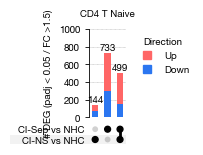

In [5]:
# Load pseudobulk DESeq2 outputs
df_ns_path_naive  = REPO_ROOT / "CINS-vs-NHC_Naive.csv"
df_sep_path_naive = REPO_ROOT / "CISep-vs-NHC_Naive.csv"

missing_naive = [p for p in [df_ns_path_naive, df_sep_path_naive] if not p.exists()]
if missing_naive:
    missing_str = "\n".join(str(p) for p in missing_naive)
    raise FileNotFoundError(
        f"Missing required Figure 5 input file(s):\n{missing_str}\n\n"
        "These files are derived from Supplementary Table 1 of the published article.\n"
        "Download from:\n"
        "https://www.nature.com/articles/s41590-025-02390-6\n"
        "and extract the corresponding CSV(s) before running this notebook."
    )

df_ns  = pd.read_csv(df_ns_path_naive, index_col=0)
df_sep = pd.read_csv(df_sep_path_naive, index_col=0)

# Filter by padj and log2FoldChange
up_ns = df_ns[(df_ns['padj'] < 0.05) & (abs(df_ns['log2FoldChange']) > 0.58)].index
up_sep = df_sep[(df_sep['padj'] < 0.05) & (abs(df_sep['log2FoldChange']) > 0.58)].index

# Separate genes into upregulated and downregulated
df_ns['Direction'] = df_ns['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')
df_sep['Direction'] = df_sep['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')

all_genes = list(set(up_ns) | set(up_sep))
membership = {
    'gene': all_genes,
    'CI-NS vs NHC': [gene in up_ns for gene in all_genes],
    'CI-Sep vs NHC': [gene in up_sep for gene in all_genes],
    'Direction': [(df_ns if gene in up_ns else df_sep).loc[gene, 'Direction'] for gene in all_genes]
}

# Create dataframe and set indices for the UpSet plot
df = pd.DataFrame(membership).set_index(['CI-NS vs NHC', 'CI-Sep vs NHC'])
df['Direction'] = pd.Categorical(df['Direction'], categories=['Up', 'Down'], ordered=True)
df.sort_values('Direction', inplace=True)

# Create UpSet plot
upset = UpSet(
    df,
    subset_size='count',
    sort_categories_by='input',
    element_size=12,
    show_counts=True,
    totals_plot_elements=0,
    intersection_plot_elements=0
)

direction_colors = {'Up': '#ff6666', 'Down': '#2b76f0'}

upset.add_stacked_bars(by='Direction', colors=direction_colors, elements=7)

plot = upset.plot()

handles = [
    mlines.Line2D([], [], color=direction_colors[direction], label=direction, marker='s', linestyle='None', markersize=6) 
    for direction in ['Up', 'Down']
]
plt.legend(handles=handles, title='Direction', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.ylim(0, 1000)
plt.yticks(np.arange(0, 1001, 200))
plt.tick_params(axis='y', width=0.6)
plt.tick_params(axis='x', width=0.6)

for y_tick in np.arange(0, 1001, 200):
    plt.axhline(y=y_tick, color='lightgrey', linestyle='-', linewidth=0.6, zorder=0)

plt.title('CD4 T Naive', y=1.05)
plt.ylabel('# DEG (padj < 0.05 / FC >1.5)')

plt.savefig(output_dir / 'Upset_CD4naive.svg', format='svg')
plt.show()

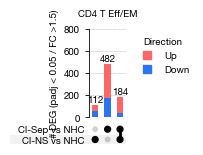

In [6]:
# Load pseudobulk DESeq2 outputs
df_ns_path_effem  = REPO_ROOT / "CINS-vs-NHC_EffEM.csv"
df_sep_path_effem = REPO_ROOT / "CISep-vs-NHC_EffEM.csv"

missing_effem = [p for p in [df_ns_path_effem, df_sep_path_effem] if not p.exists()]
if missing_effem:
    missing_str = "\n".join(str(p) for p in missing_effem)
    raise FileNotFoundError(
        f"Missing required Figure 5 input file(s):\n{missing_str}\n\n"
        "These files are derived from Supplementary Table 1 of the published article.\n"
        "Download from:\n"
        "https://www.nature.com/articles/s41590-025-02390-6\n"
        "and extract the corresponding CSV(s) before running this notebook."
    )

df_ns  = pd.read_csv(df_ns_path_effem, index_col=0)
df_sep = pd.read_csv(df_sep_path_effem, index_col=0)

# Filter by padj and log2FoldChange
up_ns = df_ns[(df_ns['padj'] < 0.05) & (abs(df_ns['log2FoldChange']) > 0.58)].index
up_sep = df_sep[(df_sep['padj'] < 0.05) & (abs(df_sep['log2FoldChange']) > 0.58)].index

# Separate genes into upregulated and downregulated
df_ns['Direction'] = df_ns['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')
df_sep['Direction'] = df_sep['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')

all_genes = list(set(up_ns) | set(up_sep))
membership = {
    'gene': all_genes,
    'CI-NS vs NHC': [gene in up_ns for gene in all_genes],
    'CI-Sep vs NHC': [gene in up_sep for gene in all_genes],
    'Direction': [(df_ns if gene in up_ns else df_sep).loc[gene, 'Direction'] for gene in all_genes]
}

# Create dataframe and set indices for the UpSet plot
df = pd.DataFrame(membership).set_index(['CI-NS vs NHC', 'CI-Sep vs NHC'])
df['Direction'] = pd.Categorical(df['Direction'], categories=['Up', 'Down'], ordered=True)
df.sort_values('Direction', inplace=True)

# Create UpSet plot
upset = UpSet(
    df,
    subset_size='count',
    sort_categories_by='input',
    element_size=12,
    show_counts=True,
    totals_plot_elements=0,
    intersection_plot_elements=0
)

direction_colors = {'Up': '#ff6666', 'Down': '#2b76f0'}

upset.add_stacked_bars(by='Direction', colors=direction_colors, elements=7)

plot = upset.plot()

handles = [
    mlines.Line2D([], [], color=direction_colors[direction], label=direction, marker='s', linestyle='None', markersize=6) 
    for direction in ['Up', 'Down']
]
plt.legend(handles=handles, title='Direction', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.ylim(0, 800)
plt.yticks(np.arange(0, 801, 200))
plt.tick_params(axis='y', width=0.6)
plt.tick_params(axis='x', width=0.6)

for y_tick in np.arange(0, 1001, 200):
    plt.axhline(y=y_tick, color='lightgrey', linestyle='-', linewidth=0.6, zorder=0)

plt.title('CD4 T Eff/EM', y=1.05)
plt.ylabel('# DEG (padj < 0.05 / FC >1.5)')

plt.savefig(output_dir / 'Upset_CD4TEffEM.svg', format='svg')
plt.show()

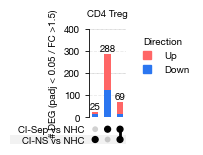

In [7]:
# Load pseudobulk DESeq2 outputs
df_ns_path_treg  = REPO_ROOT / "CINS-vs-NHC_Treg.csv"
df_sep_path_treg = REPO_ROOT / "CISep-vs-NHC_Treg.csv"

missing_treg = [p for p in [df_ns_path_treg, df_sep_path_treg] if not p.exists()]
if missing_treg:
    missing_str = "\n".join(str(p) for p in missing_treg)
    raise FileNotFoundError(
        f"Missing required Figure 5 input file(s):\n{missing_str}\n\n"
        "These files are derived from Supplementary Table 1 of the published article.\n"
        "Download from:\n"
        "https://www.nature.com/articles/s41590-025-02390-6\n"
        "and extract the corresponding CSV(s) before running this notebook."
    )

df_ns  = pd.read_csv(df_ns_path_treg, index_col=0)
df_sep = pd.read_csv(df_sep_path_treg, index_col=0)

# Filter by padj and log2FoldChange
up_ns = df_ns[(df_ns['padj'] < 0.05) & (abs(df_ns['log2FoldChange']) > 0.58)].index
up_sep = df_sep[(df_sep['padj'] < 0.05) & (abs(df_sep['log2FoldChange']) > 0.58)].index

# Separate genes into upregulated and downregulated
df_ns['Direction'] = df_ns['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')
df_sep['Direction'] = df_sep['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')

all_genes = list(set(up_ns) | set(up_sep))
membership = {
    'gene': all_genes,
    'CI-NS vs NHC': [gene in up_ns for gene in all_genes],
    'CI-Sep vs NHC': [gene in up_sep for gene in all_genes],
    'Direction': [(df_ns if gene in up_ns else df_sep).loc[gene, 'Direction'] for gene in all_genes]
}

# Create dataframe and set indices for the UpSet plot
df = pd.DataFrame(membership).set_index(['CI-NS vs NHC', 'CI-Sep vs NHC'])
df['Direction'] = pd.Categorical(df['Direction'], categories=['Up', 'Down'], ordered=True)
df.sort_values('Direction', inplace=True)

# Create UpSet plot
upset = UpSet(
    df,
    subset_size='count',
    sort_categories_by='input',
    element_size=12,
    show_counts=True,
    totals_plot_elements=0,
    intersection_plot_elements=0
)

direction_colors = {'Up': '#ff6666', 'Down': '#2b76f0'}

upset.add_stacked_bars(by='Direction', colors=direction_colors, elements=7)

plot = upset.plot()

handles = [
    mlines.Line2D([], [], color=direction_colors[direction], label=direction, marker='s', linestyle='None', markersize=6) 
    for direction in ['Up', 'Down']
]
plt.legend(handles=handles, title='Direction', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.ylim(0, 400)
plt.yticks(np.arange(0, 401, 100))
plt.tick_params(axis='y', width=0.6)
plt.tick_params(axis='x', width=0.6)

for y_tick in np.arange(0, 1001, 200):
    plt.axhline(y=y_tick, color='lightgrey', linestyle='-', linewidth=0.6, zorder=0)

plt.title('CD4 Treg', y=1.05)
plt.ylabel('# DEG (padj < 0.05 / FC >1.5)')

plt.savefig(output_dir / 'Upset_CD4Treg.svg', format='svg')
plt.show()

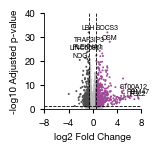

In [8]:
# Load pseudobulk DESeq2 output for naive
dge = pd.read_csv(df_sep_path_naive, index_col=0)

# Prepare dataframe
col_logfc = "log2FoldChange"
col_padj  = "padj"
col_stat  = "stat"

plot_df = dge[[col_logfc, col_padj, col_stat]].copy()
plot_df.columns = ["log2FC", "padj", "stat"]
plot_df["gene"] = plot_df.index.astype(str)

plot_df["log2FC"] = pd.to_numeric(plot_df["log2FC"], errors="coerce")
plot_df["padj"]   = pd.to_numeric(plot_df["padj"],   errors="coerce")
plot_df["stat"]   = pd.to_numeric(plot_df["stat"],   errors="coerce")
plot_df = plot_df.dropna(subset=["log2FC","padj","stat"])
plot_df["neglog10_padj"] = -np.log10(np.clip(plot_df["padj"].values, 1e-300, 1.0))

# Set thresholds and assign direction of gene expression
fc_thr = np.log2(1.5)
p_thr  = 0.05
y_thr  = -np.log10(p_thr)

plot_df["Direction"] = "NS"
plot_df.loc[(plot_df["log2FC"] >= fc_thr) & (plot_df["padj"] < p_thr), "Direction"] = "Up"
plot_df.loc[(plot_df["log2FC"] <= -fc_thr) & (plot_df["padj"] < p_thr), "Direction"] = "Down"

# Generate fold change + padj composite score for annotating genes
abs_fc = plot_df["log2FC"].abs()
abs_fc_min = abs_fc.min()
abs_fc_rng = max(abs_fc.max() - abs_fc_min, 1e-12)
fc_s = (abs_fc - abs_fc_min) / abs_fc_rng

nlp = plot_df["neglog10_padj"]
nlp_min = nlp.min()
nlp_rng = max(nlp.max() - nlp_min, 1e-12)
p_s = (nlp - nlp_min) / nlp_rng

w = 0.5
plot_df["combo_score"] = w*fc_s + (1-w)*p_s

top_up   = plot_df.loc[plot_df["Direction"]=="Up"].nlargest(5, "combo_score")
top_down = plot_df.loc[plot_df["Direction"]=="Down"].nlargest(5, "combo_score")

# Create volcano plot
fig, ax = plt.subplots(figsize=(1.25, 1.25))

ax.scatter(
    plot_df.loc[plot_df["Direction"]=="NS", "log2FC"],
    plot_df.loc[plot_df["Direction"]=="NS", "neglog10_padj"],
    s=2, c="#BBBBBB", edgecolors="none", alpha=1, zorder=1,
    rasterized=True
)

ax.scatter(
    plot_df.loc[plot_df["Direction"]=="Up", "log2FC"],
    plot_df.loc[plot_df["Direction"]=="Up", "neglog10_padj"],
    s=2, c="#9F4A96", edgecolors="none", alpha=1, zorder=2,
    rasterized=True
)

ax.scatter(
    plot_df.loc[plot_df["Direction"]=="Down", "log2FC"],
    plot_df.loc[plot_df["Direction"]=="Down", "neglog10_padj"],
    s=2, c="#4D4D4D", edgecolors="none", alpha=1, zorder=2,
    rasterized=True
)

ax.axvline(+fc_thr, color="black", linestyle="--", linewidth=0.6, zorder=3)
ax.axvline(-fc_thr, color="black", linestyle="--", linewidth=0.6, zorder=3)
ax.axhline(y_thr,  color="black", linestyle="--", linewidth=0.6, zorder=3)

ax.set_xlim(-8, 8)
ax.set_ylim(0, 40)
ax.set_xticks([-8, -4, 0, 4, 8])
ax.set_xlabel("log2 Fold Change")
ax.set_ylabel("-log10 Adjusted p-value")

label_df = pd.concat([top_up, top_down], axis=0)
for _, r in label_df.iterrows():
    ax.text(r["log2FC"], r["neglog10_padj"] + 0.6, r["gene"],
            fontsize=5, ha="center", va="bottom", color="black")

plt.savefig(output_dir / "CD4TNaive_volcano.svg", dpi=1200)
plt.show()

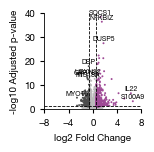

In [9]:
# Load pseudobulk DESeq2 output for Eff/EM
dge = pd.read_csv(df_sep_path_effem, index_col=0)

# Prepare dataframe
col_logfc = "log2FoldChange"
col_padj  = "padj"
col_stat  = "stat"

plot_df = dge[[col_logfc, col_padj, col_stat]].copy()
plot_df.columns = ["log2FC", "padj", "stat"]
plot_df["gene"] = plot_df.index.astype(str)

plot_df["log2FC"] = pd.to_numeric(plot_df["log2FC"], errors="coerce")
plot_df["padj"]   = pd.to_numeric(plot_df["padj"],   errors="coerce")
plot_df["stat"]   = pd.to_numeric(plot_df["stat"],   errors="coerce")
plot_df = plot_df.dropna(subset=["log2FC","padj","stat"])
plot_df["neglog10_padj"] = -np.log10(np.clip(plot_df["padj"].values, 1e-300, 1.0))

# Set thresholds and assign direction of gene expression
fc_thr = np.log2(1.5)
p_thr  = 0.05
y_thr  = -np.log10(p_thr)

plot_df["Direction"] = "NS"
plot_df.loc[(plot_df["log2FC"] >= fc_thr) & (plot_df["padj"] < p_thr), "Direction"] = "Up"
plot_df.loc[(plot_df["log2FC"] <= -fc_thr) & (plot_df["padj"] < p_thr), "Direction"] = "Down"

# Generate fold change + padj composite score for annotating genes
abs_fc = plot_df["log2FC"].abs()
abs_fc_min = abs_fc.min()
abs_fc_rng = max(abs_fc.max() - abs_fc_min, 1e-12)
fc_s = (abs_fc - abs_fc_min) / abs_fc_rng

nlp = plot_df["neglog10_padj"]
nlp_min = nlp.min()
nlp_rng = max(nlp.max() - nlp_min, 1e-12)
p_s = (nlp - nlp_min) / nlp_rng

w = 0.5
plot_df["combo_score"] = w*fc_s + (1-w)*p_s

top_up   = plot_df.loc[plot_df["Direction"]=="Up"].nlargest(5, "combo_score")
top_down = plot_df.loc[plot_df["Direction"]=="Down"].nlargest(5, "combo_score")

# Create volcano plot
fig, ax = plt.subplots(figsize=(1.25, 1.25))

ax.scatter(
    plot_df.loc[plot_df["Direction"]=="NS", "log2FC"],
    plot_df.loc[plot_df["Direction"]=="NS", "neglog10_padj"],
    s=2, c="#BBBBBB", edgecolors="none", alpha=1, zorder=1,
    rasterized=True
)

ax.scatter(
    plot_df.loc[plot_df["Direction"]=="Up", "log2FC"],
    plot_df.loc[plot_df["Direction"]=="Up", "neglog10_padj"],
    s=2, c="#9F4A96", edgecolors="none", alpha=1, zorder=2,
    rasterized=True
)

ax.scatter(
    plot_df.loc[plot_df["Direction"]=="Down", "log2FC"],
    plot_df.loc[plot_df["Direction"]=="Down", "neglog10_padj"],
    s=2, c="#4D4D4D", edgecolors="none", alpha=1, zorder=2,
    rasterized=True
)

ax.axvline(+fc_thr, color="black", linestyle="--", linewidth=0.6, zorder=3)
ax.axvline(-fc_thr, color="black", linestyle="--", linewidth=0.6, zorder=3)
ax.axhline(y_thr,  color="black", linestyle="--", linewidth=0.6, zorder=3)

ax.set_xlim(-8, 8)
ax.set_ylim(0, 40)
ax.set_xticks([-8, -4, 0, 4, 8])
ax.set_xlabel("log2 Fold Change")
ax.set_ylabel("-log10 Adjusted p-value")

label_df = pd.concat([top_up, top_down], axis=0)
for _, r in label_df.iterrows():
    ax.text(r["log2FC"], r["neglog10_padj"] + 0.6, r["gene"],
            fontsize=5, ha="center", va="bottom", color="black")

plt.savefig(output_dir / "CD4TEffEM_volcano.svg", dpi=1200)
plt.show()

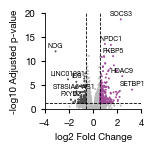

In [10]:
# Load pseudobulk DESeq2 output for Treg
dge = pd.read_csv(df_sep_path_treg, index_col=0)

# Prepare dataframe
col_logfc = "log2FoldChange"
col_padj  = "padj"
col_stat  = "stat"

plot_df = dge[[col_logfc, col_padj, col_stat]].copy()
plot_df.columns = ["log2FC", "padj", "stat"]
plot_df["gene"] = plot_df.index.astype(str)

plot_df["log2FC"] = pd.to_numeric(plot_df["log2FC"], errors="coerce")
plot_df["padj"]   = pd.to_numeric(plot_df["padj"],   errors="coerce")
plot_df["stat"]   = pd.to_numeric(plot_df["stat"],   errors="coerce")
plot_df = plot_df.dropna(subset=["log2FC","padj","stat"])
plot_df["neglog10_padj"] = -np.log10(np.clip(plot_df["padj"].values, 1e-300, 1.0))

# Set thresholds and assign direction of gene expression
fc_thr = np.log2(1.5)
p_thr  = 0.05
y_thr  = -np.log10(p_thr)

plot_df["Direction"] = "NS"
plot_df.loc[(plot_df["log2FC"] >= fc_thr) & (plot_df["padj"] < p_thr), "Direction"] = "Up"
plot_df.loc[(plot_df["log2FC"] <= -fc_thr) & (plot_df["padj"] < p_thr), "Direction"] = "Down"

# Generate fold change + padj composite score for annotating genes
abs_fc = plot_df["log2FC"].abs()
abs_fc_min = abs_fc.min()
abs_fc_rng = max(abs_fc.max() - abs_fc_min, 1e-12)
fc_s = (abs_fc - abs_fc_min) / abs_fc_rng

nlp = plot_df["neglog10_padj"]
nlp_min = nlp.min()
nlp_rng = max(nlp.max() - nlp_min, 1e-12)
p_s = (nlp - nlp_min) / nlp_rng

w = 0.5
plot_df["combo_score"] = w*fc_s + (1-w)*p_s

top_up   = plot_df.loc[plot_df["Direction"]=="Up"].nlargest(5, "combo_score")
top_down = plot_df.loc[plot_df["Direction"]=="Down"].nlargest(5, "combo_score")

# Create volcano plot
fig, ax = plt.subplots(figsize=(1.25, 1.25))

ax.scatter(
    plot_df.loc[plot_df["Direction"]=="NS", "log2FC"],
    plot_df.loc[plot_df["Direction"]=="NS", "neglog10_padj"],
    s=2, c="#BBBBBB", edgecolors="none", alpha=1, zorder=1,
    rasterized=True
)

ax.scatter(
    plot_df.loc[plot_df["Direction"]=="Up", "log2FC"],
    plot_df.loc[plot_df["Direction"]=="Up", "neglog10_padj"],
    s=2, c="#9F4A96", edgecolors="none", alpha=1, zorder=2,
    rasterized=True
)

ax.scatter(
    plot_df.loc[plot_df["Direction"]=="Down", "log2FC"],
    plot_df.loc[plot_df["Direction"]=="Down", "neglog10_padj"],
    s=2, c="#4D4D4D", edgecolors="none", alpha=1, zorder=2,
    rasterized=True
)

ax.axvline(+fc_thr, color="black", linestyle="--", linewidth=0.6, zorder=3)
ax.axvline(-fc_thr, color="black", linestyle="--", linewidth=0.6, zorder=3)
ax.axhline(y_thr,  color="black", linestyle="--", linewidth=0.6, zorder=3)

ax.set_xlim(-4, 4)
ax.set_ylim(0, 20)
ax.set_xticks([-4, -2, 0, 2, 4])
ax.set_xlabel("log2 Fold Change")
ax.set_ylabel("-log10 Adjusted p-value")

label_df = pd.concat([top_up, top_down], axis=0)
for _, r in label_df.iterrows():
    ax.text(r["log2FC"], r["neglog10_padj"] + 0.6, r["gene"],
            fontsize=5, ha="center", va="bottom", color="black")

plt.savefig(output_dir / "CD4Treg_volcano.svg", dpi=1200)
plt.show()

In [11]:
# Get msigdb for ORA
msigdb = dc.get_resource("MSigDB")

                                                        Term      p-value  FDR p-value  Odds ratio  Combined score
                Positive Regulation Of Immune System Process 5.051116e-15 2.993475e-12    1.770878       58.295834
                                Type I Interferon Production 2.126251e-09 1.777055e-07    2.966075       59.229274
         Negative Regulation Of Phosphorus Metabolic Process 6.287205e-13 1.863013e-10    2.114150       59.397229
Regulation Of Cd8 Positive Alpha Beta T Cell Differentiation 6.047792e-05 1.166436e-03    6.498781       63.124170
      Growth Hormone Receptor Signaling Pathway Via Jak Stat 6.047792e-05 1.166436e-03    6.498781       63.124170
                                       Lymphocyte Activation 2.874814e-16 2.342614e-13    1.928819       69.023500
                            Regulation Of Response To Stress 4.354658e-18 5.677603e-15    1.729219       69.126014
                                 Cellular Response To Stress 4.376128e-19 1.1127

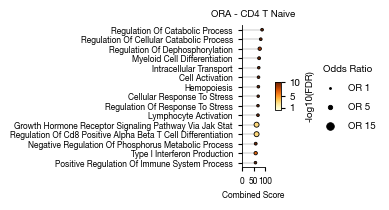

In [12]:
# Load pseudobulk DESeq2 output for naive
results_df = pd.read_csv(df_sep_path_naive, index_col=0)
results_df.index = results_df.index.str.upper()
results_df.index.name = "genesymbol"

# Sig up (padj<0.05 & log2FC>0)
top_genes = results_df[(results_df["padj"] < 0.05) & (results_df["log2FoldChange"] > 0)]

# Select GO:BP from msigdb and run ORA
msigdb = msigdb[msigdb["collection"] == "go_biological_process"]
msigdb["genesymbol"] = msigdb["genesymbol"].str.upper()
msigdb = msigdb[~msigdb.duplicated(["geneset","genesymbol"])]

enr = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source="geneset",
    target="genesymbol"
)

enr.to_csv(REPO_ROOT / "ORA_CISep-vs-NHC_Naive.csv", index=False)

# Select top 15 by combined score and prepare for plotting
top15 = (enr.sort_values("Combined score", ascending=False)
           .head(15).copy())

top15["Term"] = (top15["Term"]
                 .str.replace(r"^GOBP_", "", regex=True)
                 .str.replace("_", " ")
                 .str.title())

top15 = top15.sort_values("Combined score")

for c in ["Combined score","p-value","FDR p-value","Odds ratio"]:
    top15[c] = pd.to_numeric(top15[c], errors="coerce")

print(top15[["Term","p-value","FDR p-value","Odds ratio","Combined score"]]
      .to_string(index=False))

# Dot plot
plt.figure(figsize=(0.5, 1.85))
sc = plt.scatter(
    x=top15["Combined score"],
    y=top15["Term"],
    s=top15["Odds ratio"]*2,
    c=-np.log10(top15["FDR p-value"]),
    cmap="YlOrBr",
    edgecolor="black",
    vmin=0, vmax=10,
    zorder=2
)

cbar = plt.colorbar(sc, shrink=0.2, aspect=5, pad=0.25)
cbar.set_label("-log10(FDR)")
cbar.set_ticks([1, 5, 10]) 

for size in [1, 5, 15]:
    plt.scatter([], [], s=size*2, c="black", alpha=1, edgecolor="black",
                label=f"OR {size}")

plt.legend(scatterpoints=1, frameon=False, labelspacing=1,
           title="Odds Ratio", loc="lower left", bbox_to_anchor=(3, 0.2))

plt.hlines(y=top15["Term"], xmin=0, xmax=top15["Combined score"], 
           color="grey", linewidth=0.3, zorder=1)

plt.xlabel("Combined Score", fontsize=6)
plt.ylabel("", fontsize=6)
plt.title("ORA - CD4 T Naive")
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 50), fontsize=6)
plt.yticks(fontsize=6)

plt.ylim(-0.5, len(top15)-0.5)

plt.savefig(output_dir / "ORA_CD4Naive.svg")
plt.show()

                                                                            Term      p-value  FDR p-value  Odds ratio  Combined score
                                                       Germinal Center Formation 3.700264e-04 1.153540e-02    5.812174       45.927425
                                                                     Hemopoiesis 1.906778e-11 3.786225e-08    1.895857       46.795482
                                                     Cellular Response To Stress 5.744645e-13 3.422085e-09    1.674020       47.182820
                                         Piecemeal Microautophagy Of The Nucleus 4.982551e-04 1.374123e-02    6.788470       51.622227
                                                       Nk T Cell Differentiation 4.982551e-04 1.374123e-02    6.788470       51.622227
                                                          Toll Signaling Pathway 1.031732e-03 2.301882e-02    7.772012       53.444368
                                                 Immuno

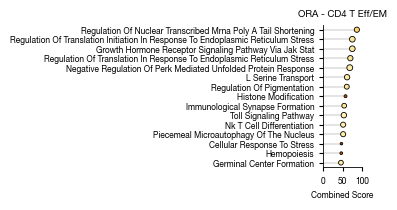

In [13]:
# Load pseudobulk DESeq2 output for Eff/EM
results_df = pd.read_csv(df_sep_path_effem, index_col=0)
results_df.index = results_df.index.str.upper()
results_df.index.name = "genesymbol"

# Sig up (padj<0.05 & log2FC>0)
top_genes = results_df[(results_df["padj"] < 0.05) & (results_df["log2FoldChange"] > 0)]

# Select GO:BP from msigdb and run ORA
msigdb = msigdb[msigdb["collection"] == "go_biological_process"]
msigdb["genesymbol"] = msigdb["genesymbol"].str.upper()
msigdb = msigdb[~msigdb.duplicated(["geneset","genesymbol"])]

enr = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source="geneset",
    target="genesymbol"
)

enr.to_csv(REPO_ROOT / "ORA_CISep-vs-NHC_EffEM.csv", index=False)

# Select top 15 by combined score and prepare for plotting
top15 = (enr.sort_values("Combined score", ascending=False)
           .head(15).copy())

top15["Term"] = (top15["Term"]
                 .str.replace(r"^GOBP_", "", regex=True)
                 .str.replace("_", " ")
                 .str.title())

top15 = top15.sort_values("Combined score")

for c in ["Combined score","p-value","FDR p-value","Odds ratio"]:
    top15[c] = pd.to_numeric(top15[c], errors="coerce")

print(top15[["Term","p-value","FDR p-value","Odds ratio","Combined score"]]
      .to_string(index=False))

# Dot plot
plt.figure(figsize=(0.5, 1.85))
sc = plt.scatter(
    x=top15["Combined score"],
    y=top15["Term"],
    s=top15["Odds ratio"]*2,
    c=-np.log10(top15["FDR p-value"]),
    cmap="YlOrBr",
    edgecolor="black",
    vmin=0, vmax=10,
    zorder=2
)

plt.hlines(y=top15["Term"], xmin=0, xmax=top15["Combined score"], 
           color="grey", linewidth=0.3, zorder=1)

plt.xlabel("Combined Score", fontsize=6)
plt.ylabel("", fontsize=6)
plt.title("ORA - CD4 T Eff/EM")
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 50), fontsize=6)
plt.yticks(fontsize=6)

plt.ylim(-0.5, len(top15)-0.5)

plt.savefig(output_dir / "ORA_CD4EffEM.svg")
plt.show()

                                                                             Term      p-value  FDR p-value  Odds ratio  Combined score
                                           Toll Like Receptor 3 Signaling Pathway 1.048050e-04 3.258166e-03   10.827680       99.218465
                                   Cd4 Positive Alpha Beta T Cell Differentiation 6.729829e-08 1.543610e-05    6.378299      105.332067
                                                        Glucose Catabolic Process 2.860582e-05 1.234299e-03   10.201901      106.731275
                           Growth Hormone Receptor Signaling Pathway Via Jak Stat 9.127112e-04 1.541704e-02   15.755418      110.273605
                                        Cd4 Positive Alpha Beta T Cell Activation 7.305936e-09 2.506508e-06    5.977230      111.980884
                                                Alpha Beta T Cell Differentiation 1.814309e-09 8.785288e-07    6.116294      123.106072
Intrinsic Apoptotic Signaling Pathway In Respons

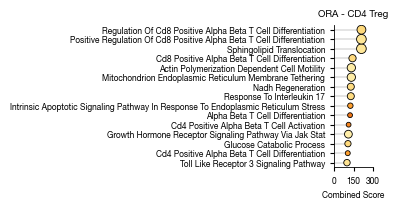

In [14]:
# Load pseudobulk DESeq2 output for Treg
results_df = pd.read_csv(df_sep_path_treg, index_col=0)
results_df.index = results_df.index.str.upper()
results_df.index.name = "genesymbol"

# Sig up (padj<0.05 & log2FC>0)
top_genes = results_df[(results_df["padj"] < 0.05) & (results_df["log2FoldChange"] > 0)]

# Select GO:BP from msigdb and run ORA
msigdb = msigdb[msigdb["collection"] == "go_biological_process"]
msigdb["genesymbol"] = msigdb["genesymbol"].str.upper()
msigdb = msigdb[~msigdb.duplicated(["geneset","genesymbol"])]

enr = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source="geneset",
    target="genesymbol"
)

enr.to_csv(REPO_ROOT / "ORA_CISep-vs-NHC_Treg.csv", index=False)

# Select top 15 by combined score and prepare for plotting
top15 = (enr.sort_values("Combined score", ascending=False)
           .head(15).copy())

top15["Term"] = (top15["Term"]
                 .str.replace(r"^GOBP_", "", regex=True)
                 .str.replace("_", " ")
                 .str.title())

top15 = top15.sort_values("Combined score")

for c in ["Combined score","p-value","FDR p-value","Odds ratio"]:
    top15[c] = pd.to_numeric(top15[c], errors="coerce")

print(top15[["Term","p-value","FDR p-value","Odds ratio","Combined score"]]
      .to_string(index=False))

# Dot plot
plt.figure(figsize=(0.5, 1.85))
sc = plt.scatter(
    x=top15["Combined score"],
    y=top15["Term"],
    s=top15["Odds ratio"]*2,
    c=-np.log10(top15["FDR p-value"]),
    cmap="YlOrBr",
    edgecolor="black",
    vmin=0, vmax=10,
    zorder=2
)

plt.hlines(y=top15["Term"], xmin=0, xmax=top15["Combined score"], 
           color="grey", linewidth=0.3, zorder=1)

plt.xlabel("Combined Score", fontsize=6)
plt.ylabel("", fontsize=6)
plt.title("ORA - CD4 Treg")
plt.xlim(0, 300)
plt.xticks(np.arange(0, 301, 150), fontsize=6)
plt.yticks(fontsize=6)

plt.ylim(-0.5, len(top15)-0.5)

plt.savefig(output_dir / "ORA_CD4Treg.svg")
plt.show()

In [15]:
# Subset to CD4 T cell types of interest
subset_celltypes = ["CD4 T Naive", "CD4 T Eff/EM", "CD4 Treg"]

adata_subset = adata[adata.obs["celltype_fine"].isin(subset_celltypes)].copy()

adata_subset.var_names = adata_subset.var_names.str.upper()

# Create combined group label and set plotting order
adata_subset.obs["Group_CellType"] = (
    adata_subset.obs["Group"].astype(str) + " " + adata_subset.obs["celltype_fine"].astype(str)
)

order = [
    "NHC CD4 T Naive",
    "CI-Sep CD4 T Naive",
    "NHC CD4 T Eff/EM",
    "CI-Sep CD4 T Eff/EM",
    "NHC CD4 Treg",
    "CI-Sep CD4 Treg",
]

adata_subset.obs["Group_CellType"] = adata_subset.obs["Group_CellType"].astype(
    pd.CategoricalDtype(categories=order, ordered=True)
)

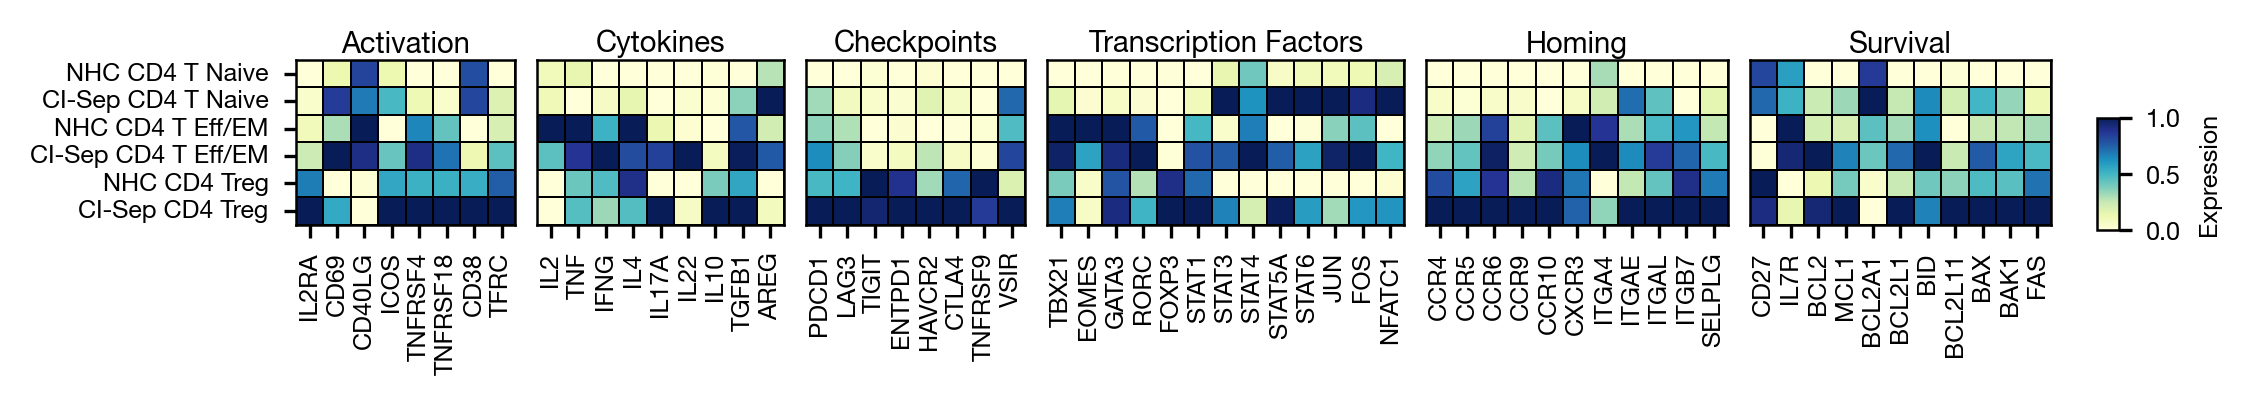

In [16]:
# Define gene categories
gene_groups = {
    "Activation": ["IL2RA", "CD69", "CD40LG", "ICOS", "TNFRSF4", "TNFRSF18", "CD38", "TFRC"],
    "Cytokines": ["IL2", "TNF", "IFNG", "IL4", "IL17A", "IL22", "IL10", "TGFB1", "AREG"],
    "Checkpoints": ["PDCD1", "LAG3", "TIGIT", "ENTPD1", "HAVCR2", "CTLA4", "TNFRSF9", "VSIR"],
    "Transcription Factors": ["TBX21", "EOMES", "GATA3", "RORC", "FOXP3", "STAT1", "STAT3", "STAT4", "STAT5A", "STAT6", "JUN", "FOS", "NFATC1"],
    "Homing": ["CCR4", "CCR5", "CCR6", "CCR9", "CCR10", "CXCR3", "ITGA4", "ITGAE", "ITGAL", "ITGB7", "SELPLG"],
    "Survival": ["CD27", "IL7R", "BCL2", "MCL1", "BCL2A1", "BCL2L1", "BID", "BCL2L11", "BAX", "BAK1", "FAS"]
}

# Flatten gene list
genes_of_interest = [g for group in gene_groups.values() for g in group]

# Compute expression matrix
matrix_data = (
    adata_subset.raw.to_adata().to_df()[genes_of_interest]
    .groupby(adata_subset.obs["Group_CellType"])
    .mean()
)

# Min/max scaling per gene
matrix_data = (matrix_data - matrix_data.min()) / (matrix_data.max() - matrix_data.min())

# Setup overall plot structure
n_rows = matrix_data.shape[0]
n_categories = len(gene_groups)
cell_in = 0.125
heatmap_spacing = 0.01

widths = [len(glist) for glist in gene_groups.values()]
fig = plt.figure(dpi=300)
gs = gridspec.GridSpec(1, n_categories, width_ratios=widths, wspace=heatmap_spacing / cell_in)

# Plot heatmap for each category
for i, (label, gene_list) in enumerate(gene_groups.items()):
    ax = fig.add_subplot(gs[0, i])
    sns.heatmap(
        matrix_data[gene_list],
        ax=ax,
        cmap="YlGnBu",
        linewidths=0.4,
        linecolor="black",
        cbar=False,
        xticklabels=True,
        yticklabels=i == 0,
    )

    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.6)

    ax.set_aspect("equal")
    ax.set_title(label, fontsize=7, pad=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=6)
    if i != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Dynamically set figure size
total_width = sum(len(g) for g in gene_groups.values()) * cell_in + (n_categories - 1) * heatmap_spacing
fig_height = n_rows * cell_in
fig.set_size_inches(total_width, fig_height + 0.75)

# Create colorbar
sm = ScalarMappable(cmap="YlGnBu", norm=Normalize(vmin=0, vmax=1))
sm.set_array([])

cax = fig.add_axes([0.92, 0.3, 0.01, 0.25])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Expression", fontsize=6)
cbar.ax.tick_params(labelsize=6)

plt.savefig(output_dir / "CD4_function_heatmap.svg", format="svg")
plt.show()

In [17]:
# Load pseudobulk DESeq2 output for naive
df = pd.read_csv(df_sep_path_naive, index_col=1)

# Prepare the ranked list using gene names and Wald statistics
rnk_file = df[["Unnamed: 0", "stat"]].copy()
rnk_file.columns = ["Gene", "Score"]
rnk_file["Gene"] = rnk_file["Gene"].str.upper()
rnk_file = rnk_file.drop_duplicates().sort_values(by="Score", ascending=False)

# Run preranked GSEA
pre_res = gp.prerank(
    rnk=rnk_file,
    gene_sets="KEGG_2021_Human",
    min_size=15,
    max_size=500,
    permutation_num=1000,
    outdir=REPO_ROOT / "gsea_results_kegg_cd4tnaive",
    seed=42,
    verbose=True
)

2026-01-13 09:04:01,646 [INFO] Parsing data files for GSEA.............................
2026-01-13 09:04:01,646 [INFO] Enrichr library gene sets already downloaded in: /home/mstier/.cache/gseapy, use local file
2026-01-13 09:04:01,655 [INFO] 0035 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-13 09:04:01,655 [INFO] 0285 gene_sets used for further statistical testing.....
2026-01-13 09:04:01,656 [INFO] Start to run GSEA...Might take a while..................
2026-01-13 09:04:11,251 [INFO] Start to generate gseapy reports, and produce figures...
2026-01-13 09:04:11,252 [INFO] Congratulations. GSEApy runs successfully................



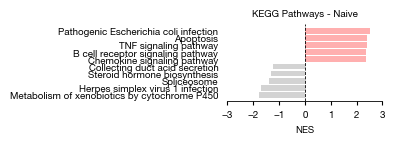

In [18]:
# Load GSEA results for naive
df = pd.read_csv(REPO_ROOT / "gsea_results_kegg_cd4tnaive" / "gseapy.gene_set.prerank.report.naive.csv")

# Filter to top 5 highest and 5 lowest NES
df_sorted = df.sort_values("NES", ascending=False)
df_up = df_sorted.head(5)
df_down = df_sorted.tail(5)
top10 = pd.concat([df_up, df_down])
top10 = top10[::-1]

# Create bar plot
direction_colors = {"Up": "#ffafaf", "Down": "#82aef6"}
colors = []
for _, row in top10.iterrows():
    if row["FDR q-val"] < 0.05:
        colors.append(direction_colors["Up"] if row["NES"] > 0 else direction_colors["Down"])
    else:
        colors.append("lightgrey")

plt.figure(figsize=(2, 1))
bars = plt.barh(
    y=top10["Term"],
    width=top10["NES"],
    color=colors,
    edgecolor="black",
    linewidth=0
)

plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(axis='y', left=False)

plt.axvline(0, color='black', linestyle='--', linewidth=0.6)
plt.xlabel("NES")
plt.xlim(-3, 3)
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.ylabel("")
plt.title("KEGG Pathways - Naive")

plt.savefig(output_dir / "GSEA_top_CD4Naive.svg")
plt.show()

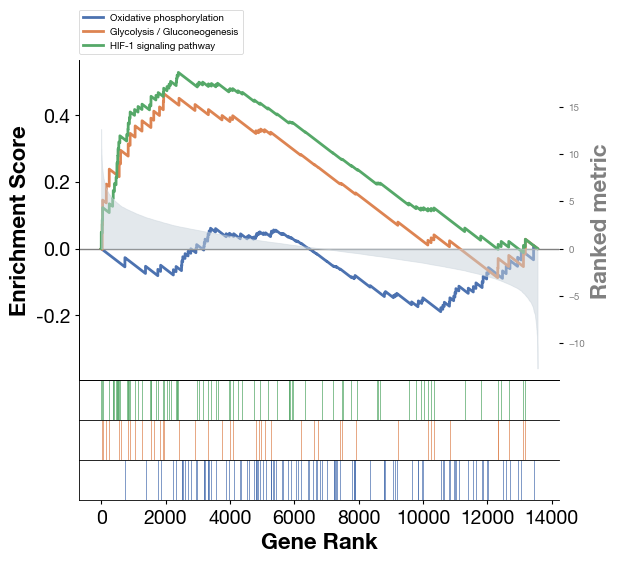

Pathway: HIF-1 signaling pathway
  NES: 2.168022247567273
  FDR q-value: 8.611036511454658e-05

Pathway: Glycolysis / Gluconeogenesis
  NES: 1.676171624159524
  FDR q-value: 0.012158151551494238

Pathway: Oxidative phosphorylation
  NES: -0.8545979621171014
  FDR q-value: 1.0



In [19]:
# Pathways for running score plot
pathways_to_plot = [
    "Oxidative phosphorylation",
    "Glycolysis / Gluconeogenesis",
    "HIF-1 signaling pathway"
]

available_pathways = [p for p in pathways_to_plot if p in pre_res.res2d["Term"].values]

# Plot
if available_pathways:

    axs = pre_res.plot(
        terms=available_pathways
    )
    
    plt.savefig(output_dir / "GSEA_running_metabolic_CD4Naive.svg")
    plt.show()

    filtered_results = pre_res.res2d[pre_res.res2d["Term"].isin(available_pathways)]
    for _, row in filtered_results.iterrows():
        term = row["Term"]
        nes = row.get("NES", "N/A")
        q_value = row.get("FDR q-val", row.get("Adjusted P-value", "N/A"))
        print(f"Pathway: {term}\n  NES: {nes}\n  FDR q-value: {q_value}\n")

In [20]:
# Load pseudobulk DESeq2 output for Eff/EM
df = pd.read_csv(df_sep_path_effem, index_col=1)

# Prepare the ranked list using gene names and Wald statistics
rnk_file = df[["Unnamed: 0", "stat"]].copy()
rnk_file.columns = ["Gene", "Score"]
rnk_file["Gene"] = rnk_file["Gene"].str.upper()
rnk_file = rnk_file.drop_duplicates().sort_values(by="Score", ascending=False)

# Run preranked GSEA
pre_res = gp.prerank(
    rnk=rnk_file,
    gene_sets="KEGG_2021_Human",
    min_size=15,
    max_size=500,
    permutation_num=1000,
    outdir=REPO_ROOT / "gsea_results_kegg_cd4teffem",
    seed=42,
    verbose=True
)

2026-01-13 09:04:11,718 [INFO] Parsing data files for GSEA.............................
2026-01-13 09:04:11,718 [INFO] Enrichr library gene sets already downloaded in: /home/mstier/.cache/gseapy, use local file
2026-01-13 09:04:11,726 [INFO] 0036 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-13 09:04:11,727 [INFO] 0284 gene_sets used for further statistical testing.....
2026-01-13 09:04:11,727 [INFO] Start to run GSEA...Might take a while..................
2026-01-13 09:04:21,774 [INFO] Start to generate gseapy reports, and produce figures...
2026-01-13 09:04:21,775 [INFO] Congratulations. GSEApy runs successfully................



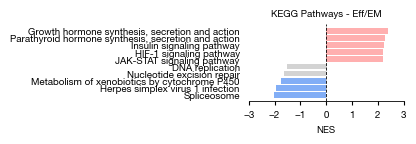

In [21]:
# Load GSEA results for Eff/EM
df = pd.read_csv(REPO_ROOT / "gsea_results_kegg_cd4teffem" / "gseapy.gene_set.prerank.report.effem.csv")

# Filter to top 5 highest and 5 lowest NES
df_sorted = df.sort_values("NES", ascending=False)
df_up = df_sorted.head(5)
df_down = df_sorted.tail(5)
top10 = pd.concat([df_up, df_down])
top10 = top10[::-1]

# Create bar plot
direction_colors = {"Up": "#ffafaf", "Down": "#82aef6"}
colors = []
for _, row in top10.iterrows():
    if row["FDR q-val"] < 0.05:
        colors.append(direction_colors["Up"] if row["NES"] > 0 else direction_colors["Down"])
    else:
        colors.append("lightgrey")

plt.figure(figsize=(2, 1))
bars = plt.barh(
    y=top10["Term"],
    width=top10["NES"],
    color=colors,
    edgecolor="black",
    linewidth=0
)

plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(axis='y', left=False)

plt.axvline(0, color='black', linestyle='--', linewidth=0.6)
plt.xlabel("NES")
plt.xlim(-3, 3)
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.ylabel("")
plt.title("KEGG Pathways - Eff/EM")

plt.savefig(output_dir / "GSEA_top_CD4EffEM.svg")
plt.show()

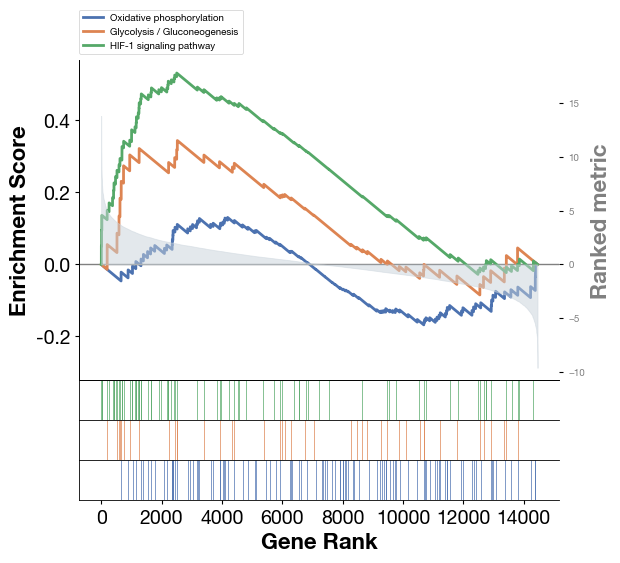

Pathway: HIF-1 signaling pathway
  NES: 2.180179579681274
  FDR q-value: 0.0003681255231659406

Pathway: Glycolysis / Gluconeogenesis
  NES: 1.2454842445816854
  FDR q-value: 0.17599672234204547

Pathway: Oxidative phosphorylation
  NES: -0.7542048506846785
  FDR q-value: 0.9701827428884845



In [22]:
# Pathways for running score plot
pathways_to_plot = [
    "Oxidative phosphorylation",
    "Glycolysis / Gluconeogenesis",
    "HIF-1 signaling pathway"
]

available_pathways = [p for p in pathways_to_plot if p in pre_res.res2d["Term"].values]

# Plot and summarize results
if available_pathways:
    # Plot selected metabolic pathways
    axs = pre_res.plot(
        terms=available_pathways
    )
    
    # Save as SVG
    plt.savefig(output_dir / "GSEA_running_metabolic_CD4EffEM.svg")
    plt.show()

    # Print NES and q-values
    filtered_results = pre_res.res2d[pre_res.res2d["Term"].isin(available_pathways)]
    for _, row in filtered_results.iterrows():
        term = row["Term"]
        nes = row.get("NES", "N/A")
        q_value = row.get("FDR q-val", row.get("Adjusted P-value", "N/A"))
        print(f"Pathway: {term}\n  NES: {nes}\n  FDR q-value: {q_value}\n")

In [23]:
# Load pseudobulk DESeq2 output for Treg
df = pd.read_csv(df_sep_path_treg, index_col=1)

# Prepare the ranked list using gene names and Wald statistics
rnk_file = df[["Unnamed: 0", "stat"]].copy()
rnk_file.columns = ["Gene", "Score"]
rnk_file["Gene"] = rnk_file["Gene"].str.upper()
rnk_file = rnk_file.drop_duplicates().sort_values(by="Score", ascending=False)

# Run preranked GSEA
pre_res = gp.prerank(
    rnk=rnk_file,
    gene_sets="KEGG_2021_Human",
    min_size=15,
    max_size=500,
    permutation_num=1000,
    outdir=REPO_ROOT / "gsea_results_kegg_cd4treg",
    seed=42,
    verbose=True
)

2026-01-13 09:04:22,285 [INFO] Parsing data files for GSEA.............................
2026-01-13 09:04:22,286 [INFO] Enrichr library gene sets already downloaded in: /home/mstier/.cache/gseapy, use local file
2026-01-13 09:04:22,294 [INFO] 0046 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-13 09:04:22,294 [INFO] 0274 gene_sets used for further statistical testing.....
2026-01-13 09:04:22,294 [INFO] Start to run GSEA...Might take a while..................
2026-01-13 09:04:31,010 [INFO] Start to generate gseapy reports, and produce figures...
2026-01-13 09:04:31,010 [INFO] Congratulations. GSEApy runs successfully................



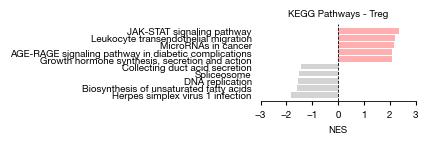

In [24]:
# Load GSEA results for Treg
df = pd.read_csv(REPO_ROOT / "gsea_results_kegg_cd4treg" / "gseapy.gene_set.prerank.report.treg.csv")

# Filter to top 5 highest and 5 lowest NES
df_sorted = df.sort_values("NES", ascending=False)
df_up = df_sorted.head(5)
df_down = df_sorted.tail(5)
top10 = pd.concat([df_up, df_down])
top10 = top10[::-1]

# Create bar plot
direction_colors = {"Up": "#ffafaf", "Down": "#82aef6"}
colors = []
for _, row in top10.iterrows():
    if row["FDR q-val"] < 0.05:
        colors.append(direction_colors["Up"] if row["NES"] > 0 else direction_colors["Down"])
    else:
        colors.append("lightgrey")

plt.figure(figsize=(2, 1))
bars = plt.barh(
    y=top10["Term"],
    width=top10["NES"],
    color=colors,
    edgecolor="black",
    linewidth=0
)

plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(axis='y', left=False)

plt.axvline(0, color='black', linestyle='--', linewidth=0.6)
plt.xlabel("NES")
plt.xlim(-3, 3)
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.ylabel("")
plt.title("KEGG Pathways - Treg")

plt.savefig(output_dir / "GSEA_top_CD4Treg.svg")
plt.show()

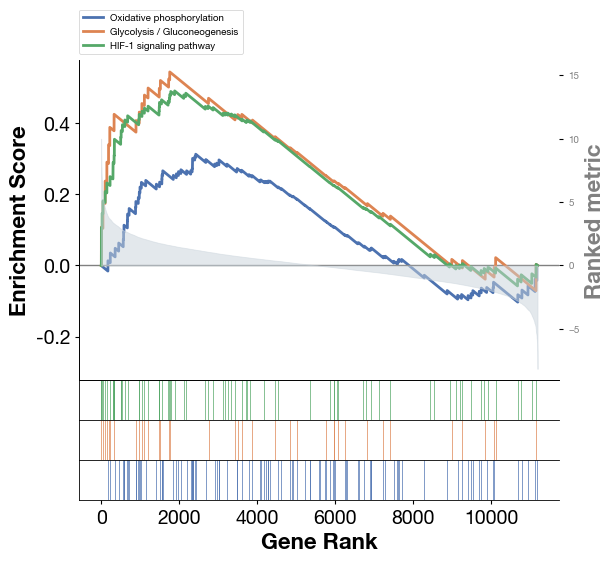

Pathway: HIF-1 signaling pathway
  NES: 2.0137638549941133
  FDR q-value: 0.0018471999045701092

Pathway: Glycolysis / Gluconeogenesis
  NES: 1.920815882728784
  FDR q-value: 0.004743426915439293

Pathway: Oxidative phosphorylation
  NES: 1.3496754521901175
  FDR q-value: 0.10854189848608455



In [25]:
# Pathways for running score plot
pathways_to_plot = [
    "Oxidative phosphorylation",
    "Glycolysis / Gluconeogenesis",
    "HIF-1 signaling pathway"
]

available_pathways = [p for p in pathways_to_plot if p in pre_res.res2d["Term"].values]

# Plot and summarize results
if available_pathways:
    # Plot selected metabolic pathways
    axs = pre_res.plot(
        terms=available_pathways
    )
    
    # Save as SVG
    plt.savefig(output_dir / "GSEA_running_metabolic_CD4Treg.svg")
    plt.show()

    # Print NES and q-values
    filtered_results = pre_res.res2d[pre_res.res2d["Term"].isin(available_pathways)]
    for _, row in filtered_results.iterrows():
        term = row["Term"]
        nes = row.get("NES", "N/A")
        q_value = row.get("FDR q-val", row.get("Adjusted P-value", "N/A"))
        print(f"Pathway: {term}\n  NES: {nes}\n  FDR q-value: {q_value}\n")

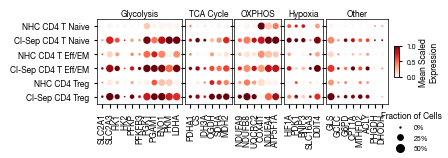

In [26]:
# Define plotting order
celltype_order = [
    'NHC CD4 T Naive', 'CI-Sep CD4 T Naive',
    'NHC CD4 T Eff/EM', 'CI-Sep CD4 T Eff/EM',
    'NHC CD4 Treg', 'CI-Sep CD4 Treg'
]

# Define gene groups
glycolysis_genes = ["SLC2A1","SLC2A3","HK1","HK2","PFKP","PFKFB3","PGK1","PGAM1","ENO1","PKM","LDHA"]
tca_genes = ["PDHA1","CS","IDH3A","OGDH","SDHA","MDH2"]
oxphos_genes = ["NDUFA9","NDUFB8","UQCRC2","COX4I1","NDUFA4","ATP5F1A"]
hypoxia_genes = ["HIF1A","PDK1","BNIP3","SLC16A3","DDIT4"]
other_metabolism_genes = ["GLS","GCLC","G6PD","CPT1A","MTHFD2","ACLY","PHGDH","DHODH"]

metabolism_genes = glycolysis_genes + tca_genes + oxphos_genes + hypoxia_genes + other_metabolism_genes

subpanel_genes = {
    "Glycolysis": glycolysis_genes,
    "TCA Cycle": tca_genes,
    "OXPHOS": oxphos_genes,
    "Hypoxia": hypoxia_genes,
    "Other": other_metabolism_genes
}

# Prepare gene expression data (mean + %expressing)
adata_exp = adata_subset.raw.to_adata()
adata_sub = adata_exp[:, metabolism_genes]
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.tocsr()

cell_types = adata_sub.obs['Group_CellType'].values
plot_data = []
for ct in celltype_order:
    idx = np.where(cell_types == ct)[0]
    if len(idx) == 0:
        continue
    X_ct = X[idx]
    mean = np.asarray(X_ct.mean(axis=0)).ravel() if scipy.sparse.issparse(X_ct) else X_ct.mean(axis=0)
    pct  = np.asarray((X_ct > 0).mean(axis=0)).ravel()*100 if scipy.sparse.issparse(X_ct) else (X_ct > 0).mean(axis=0)*100
    for gene_idx, gene in enumerate(metabolism_genes):
        plot_data.append((ct, gene, mean[gene_idx], pct[gene_idx]))

# Create dataframe for plotting
plot_df = pd.DataFrame(plot_data, columns=["celltype","genes","mean_expression","percent_cells"])
plot_df["celltype"] = pd.Categorical(plot_df["celltype"], categories=celltype_order, ordered=True)
plot_df["genes"] = pd.Categorical(plot_df["genes"], categories=metabolism_genes, ordered=True)
plot_df["percent_cells_clipped"] = np.clip(plot_df["percent_cells"], 0, 50)
plot_df["mean_expression_scaled"] = (
    plot_df.groupby("genes")["mean_expression"]
           .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6))
)

# Create dotplot
panel_widths = [len(genes) for genes in subpanel_genes.values()]
total_width = 3.9
height = 1.1

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(subpanel_genes),
    figsize=(total_width, height),
    gridspec_kw={"width_ratios": panel_widths},
    sharey=True
)

if len(subpanel_genes) == 1:
    axes = [axes]

for ax, (panel_name, genes_subset) in zip(axes, subpanel_genes.items()):
    sub_df = plot_df[plot_df["genes"].isin(genes_subset)].copy()
    sub_df["genes"] = pd.Categorical(sub_df["genes"], categories=genes_subset, ordered=True)
    sub_df["celltype"] = pd.Categorical(sub_df["celltype"], categories=celltype_order, ordered=True)

    sns.scatterplot(
        data=sub_df, x="genes", y="celltype",
        size="percent_cells_clipped", size_norm=(0, 50),
        hue="mean_expression_scaled", palette="Reds",
        sizes=(0.5, 30), legend=False, ax=ax
    )

    ax.set_xticks(np.arange(len(genes_subset)))
    ax.set_xticklabels(genes_subset, fontsize=6, rotation=90)
    ax.set_xlim(-0.75, len(genes_subset) - 0.25)
    ax.set_ylim(-0.5, len(celltype_order) - 0.5)
    ax.invert_yaxis()
    ax.set_xlabel('')
    ax.set_title(panel_name, fontsize=6, pad=2)
    ax.set_ylabel('')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)

axes[0].set_yticks(np.arange(len(celltype_order)))
axes[0].set_yticklabels(celltype_order, fontsize=6)
axes[0].tick_params(axis='y', length=2)

plt.subplots_adjust(wspace=0.05)

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap='Reds')
sm.set_array([])

cbar = fig.colorbar(
    sm, ax=axes, orientation='vertical',
    fraction=0.0175, pad=0.02, aspect=6
)
cbar.set_label("Mean Scaled\nExpression", fontsize=6, labelpad=2)
cbar.ax.tick_params(labelsize=5, length=2)

size_min, size_max = 0.5, 30
percent_values = [0, 25, 50]
size_values = [size_min + (p/50)*(size_max-size_min) for p in percent_values]

dot_handles = [
    Line2D([], [], marker='o', color='black', linestyle='None',
           markersize=np.sqrt(s), label=f"{p}%", alpha=1)
    for p, s in zip(percent_values, size_values)
]

fig.legend(
    handles=dot_handles, title="Fraction of Cells",
    loc='lower right', fontsize=5, title_fontsize=6,
    frameon=False, handletextpad=1, labelspacing=0.6, borderpad=0.5
)

plt.savefig(output_dir / "CD4_metabolism_dotplot.svg")
plt.show()